# DF CON VARIABLES DE 4 HORAS #

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score,root_mean_squared_error


In [2]:
import requests
import pandas as pd
import time

def get_binance_ohlcv(symbol="BTCUSDT", interval="1h", days=1095):
    """
    Descarga velas OHLCV desde Binance.
    symbol: par de trading (ej: BTCUSDT)
    interval: intervalo de vela (ej: 1h, 1d, 15m)
    days: días de datos hacia atrás
    """
    base_url = "https://api.binance.com/api/v3/klines"
    
    # Binance limita 1000 velas por request → dividir en chunks
    limit = 1000
    ms_interval = 60 * 60 * 1000  # 1h en milisegundos
    if interval == "1d":
        ms_interval = 24 * 60 * 60 * 1000
    
    end_time = int(time.time() * 1000)  # ahora en ms
    start_time = end_time - days * 24 * 60 * 60 * 1000
    
    all_data = []
    
    while start_time < end_time:
        params = {
            "symbol": symbol,
            "interval": interval,
            "startTime": start_time,
            "limit": limit
        }
        resp = requests.get(base_url, params=params)
        data = resp.json()
        
        if not data:
            break
        
        all_data.extend(data)
        
        # avanzar el start_time al último timestamp + intervalo
        last_open_time = data[-1][0]
        start_time = last_open_time + ms_interval
        
        time.sleep(0.2)  # para no sobrecargar la API
    
    # convertir a DataFrame
    df = pd.DataFrame(all_data, columns=[
        "open_time", "open", "high", "low", "close", "volume",
        "close_time", "quote_asset_volume", "number_of_trades",
        "taker_buy_base", "taker_buy_quote", "ignore"
    ])
    
    # limpiar tipos de datos
    df["open_time"] = pd.to_datetime(df["open_time"], unit="ms")
    df["close_time"] = pd.to_datetime(df["close_time"], unit="ms")
    for col in ["open", "high", "low", "close", "volume"]:
        df[col] = df[col].astype(float)
    
    return df[["open_time", "open", "high", "low", "close", "volume"]]

# ======================
# 🚀 Descargar datos
# ======================
df = get_binance_ohlcv("BTCUSDT", "1h", days=1095)

# guardar en CSV
df.to_csv("BTCUSDT_1h_3years.csv", index=False)

print("✅ Datos descargados y guardados en BTCUSDT_1h_3years.csv")
print(df.head())
print(df.tail())


✅ Datos descargados y guardados en BTCUSDT_1h_3years.csv
            open_time      open      high       low     close       volume
0 2022-09-26 23:00:00  19138.41  19246.33  19113.01  19227.82  13514.06311
1 2022-09-27 00:00:00  19226.68  19373.00  19187.63  19346.30  21563.77657
2 2022-09-27 01:00:00  19345.34  19894.98  19335.28  19766.56  28771.99200
3 2022-09-27 02:00:00  19765.26  20097.45  19669.85  20080.97  23231.90070
4 2022-09-27 03:00:00  20073.33  20300.00  19959.49  20099.04  28861.92426
                open_time       open       high        low      close  \
26274 2025-09-25 18:00:00  108833.63  109801.78  108631.51  109760.20   
26275 2025-09-25 19:00:00  109760.20  109973.40  109302.54  109360.00   
26276 2025-09-25 20:00:00  109360.00  109482.62  109057.06  109163.44   
26277 2025-09-25 21:00:00  109163.45  109666.30  109074.11  109420.00   
26278 2025-09-25 22:00:00  109420.00  109587.99  109312.33  109420.36   

           volume  
26274  1427.42291  
26275  1217.19

In [3]:
df

,open_time,open,high,low,close,volume
0,2022-09-26 23:00:00,19138.41,19246.33,19113.01,19227.82,13514.06311
1,2022-09-27 00:00:00,19226.68,19373.00,19187.63,19346.30,21563.77657
2,2022-09-27 01:00:00,19345.34,19894.98,19335.28,19766.56,28771.99200
3,2022-09-27 02:00:00,19765.26,20097.45,19669.85,20080.97,23231.90070
4,2022-09-27 03:00:00,20073.33,20300.00,19959.49,20099.04,28861.92426
...,...,...,...,...,...,...
26274,2025-09-25 18:00:00,108833.63,109801.78,108631.51,109760.20,1427.42291
26275,2025-09-25 19:00:00,109760.20,109973.40,109302.54,109360.00,1217.19366
26276,2025-09-25 20:00:00,109360.00,109482.62,109057.06,109163.44,424.71820
26277,2025-09-25 21:00:00,109163.45,109666.30,109074.11,109420.00,347.85454


In [4]:
#df=pd.read_csv("/home/rodrigo/Escritorio/Repositorios/Proyecto_cripto_RH/src/BTCUSDT_1h_3years.csv")+

In [5]:
#vamos a ver como funciona sin el volumen
df_porcentual=pd.DataFrame(columns=["4hora%","dia%","2dias%","1semana%"])
def porcentaje (df,columna_objetivo,n_de_intervalos,columna_nueva):

    for i in range(n_de_intervalos,len(df[columna_objetivo])):
        cambio=(df[columna_objetivo][i-n_de_intervalos]-df[columna_objetivo][i])/df[columna_objetivo][i-n_de_intervalos]
        df.loc[i,columna_nueva]=cambio*100

porcentaje(df,"close",1,"1hora%")
porcentaje(df,"close",4,"4hora%")
porcentaje(df,"close",8,"8hora%")
porcentaje(df,"close",24,"dia%")
porcentaje(df,"close",48,"2dias%")
porcentaje(df,"close",24*7,"1semana%")
porcentaje(df,"close",24*7*2,"2semanas%")
porcentaje(df,"close",24*7*4,"1mes%")
df.dropna(inplace=True)
df.reset_index(drop=True,inplace=True)

In [6]:
df_porcentual=df

In [7]:
df_porcentual["pred_dia%"]=df_porcentual["dia%"].shift(-24)

In [8]:

def calcular_RSI(df, column="close", period=14):
    """
    Calcula el RSI (Relative Strength Index) de un DataFrame.
    
    Parámetros:
        df: DataFrame con la columna de precios.
        column: columna sobre la cual calcular el RSI (por defecto 'close').
        period: ventana del RSI (por defecto 14).
        
    Retorna:
        DataFrame con una columna adicional 'RSI'.
    """
    # Calcular diferencias entre cierres
    delta = df[column].diff()

    # Separar ganancias y pérdidas
    ganancias = delta.clip(lower=0)
    perdidas = -delta.clip(upper=0)

    # Calcular medias móviles exponenciales
    media_gan = ganancias.ewm(span=period, adjust=False).mean()
    media_per = perdidas.ewm(span=period, adjust=False).mean()

    # Calcular RS y RSI
    RS = media_gan / media_per
    RSI = 100 - (100 / (1 + RS))

    df["RSI"] = RSI
    return df
calcular_RSI(df_porcentual)

,open_time,open,high,low,close,volume,1hora%,4hora%,8hora%,dia%,2dias%,1semana%,2semanas%,1mes%,pred_dia%,RSI
0,2022-10-24 23:00:00,19360.39,19365.32,19320.73,19329.72,3964.92505,0.162232,0.069844,-0.143820,1.229816,-0.652821,1.126044,-1.034138,-0.529961,-3.881846,NaN
1,2022-10-25 00:00:00,19330.60,19339.60,19276.35,19308.75,6441.26261,0.108486,0.360089,-0.186480,1.076243,-0.589301,1.467570,-1.383707,0.194094,-4.444980,0.000000
2,2022-10-25 01:00:00,19309.53,19317.38,19250.00,19297.63,7087.08928,0.057590,0.355202,-0.062793,0.591579,-0.617387,1.220967,-1.383397,2.372340,-4.833184,0.000000
3,2022-10-25 02:00:00,19298.15,19316.67,19276.38,19311.90,3915.63896,-0.073947,0.254272,0.117664,0.529393,-0.598688,0.907345,-1.342725,3.829845,-4.653763,10.046584
4,2022-10-25 03:00:00,19311.10,19365.32,19305.39,19342.02,5445.61529,-0.155966,-0.063633,0.006255,0.257581,-0.752334,1.053208,-1.560956,3.766449,-4.700388,27.729646
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25602,2025-09-25 18:00:00,108833.63,109801.78,108631.51,109760.20,1427.42291,-0.851364,1.595661,1.691017,3.413945,1.807030,6.843122,3.982203,2.325627,NaN,32.479780
25603,2025-09-25 19:00:00,109760.20,109973.40,109302.54,109360.00,1217.19366,0.364613,1.990280,1.785394,3.579624,2.055693,6.888204,4.422295,2.271072,NaN,29.335916
25604,2025-09-25 20:00:00,109360.00,109482.62,109057.06,109163.44,424.71820,0.179737,1.616703,1.752806,3.822046,2.520258,7.111657,4.574068,2.447711,NaN,27.810376
25605,2025-09-25 21:00:00,109163.45,109666.30,109074.11,109420.00,347.85454,-0.235024,-0.538776,1.423423,3.458305,2.444278,6.717189,4.422232,2.325435,NaN,33.053538


In [9]:
def agregar_emas(df, column="close", spans=[9, 21, 50, 100,200]):
    """
    Agrega columnas de EMAs al DataFrame.
    
    Parámetros:
        df: DataFrame con los precios.
        column: columna sobre la cual calcular las EMAs (default: 'close').
        spans: lista de periodos para calcular las EMAs.
        
    Retorna:
        DataFrame con nuevas columnas EMA_x.
    """
    for span in spans:
        df[f"EMA_{span}"] = df[column].ewm(span=span, adjust=False).mean()
    return df
agregar_emas(df_porcentual)

,open_time,open,high,low,close,volume,1hora%,4hora%,8hora%,dia%,...,1semana%,2semanas%,1mes%,pred_dia%,RSI,EMA_9,EMA_21,EMA_50,EMA_100,EMA_200
0,2022-10-24 23:00:00,19360.39,19365.32,19320.73,19329.72,3964.92505,0.162232,0.069844,-0.143820,1.229816,...,1.126044,-1.034138,-0.529961,-3.881846,NaN,19329.720000,19329.720000,19329.720000,19329.720000,19329.720000
1,2022-10-25 00:00:00,19330.60,19339.60,19276.35,19308.75,6441.26261,0.108486,0.360089,-0.186480,1.076243,...,1.467570,-1.383707,0.194094,-4.444980,0.000000,19325.526000,19327.813636,19328.897647,19329.304752,19329.511343
2,2022-10-25 01:00:00,19309.53,19317.38,19250.00,19297.63,7087.08928,0.057590,0.355202,-0.062793,0.591579,...,1.220967,-1.383397,2.372340,-4.833184,0.000000,19319.946800,19325.069669,19327.671465,19328.677530,19329.194116
3,2022-10-25 02:00:00,19298.15,19316.67,19276.38,19311.90,3915.63896,-0.073947,0.254272,0.117664,0.529393,...,0.907345,-1.342725,3.829845,-4.653763,10.046584,19318.337440,19323.872427,19327.052976,19328.345301,19329.022035
4,2022-10-25 03:00:00,19311.10,19365.32,19305.39,19342.02,5445.61529,-0.155966,-0.063633,0.006255,0.257581,...,1.053208,-1.560956,3.766449,-4.700388,27.729646,19323.073952,19325.522206,19327.639918,19328.616087,19329.151368
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25602,2025-09-25 18:00:00,108833.63,109801.78,108631.51,109760.20,1427.42291,-0.851364,1.595661,1.691017,3.413945,...,6.843122,3.982203,2.325627,NaN,32.479780,110682.574576,111437.243824,112149.689284,112891.820571,113725.400279
25603,2025-09-25 19:00:00,109760.20,109973.40,109302.54,109360.00,1217.19366,0.364613,1.990280,1.785394,3.579624,...,6.888204,4.422295,2.271072,NaN,29.335916,110418.059661,111248.403477,112040.289704,112821.883530,113681.963460
25604,2025-09-25 20:00:00,109360.00,109482.62,109057.06,109163.44,424.71820,0.179737,1.616703,1.752806,3.822046,...,7.111657,4.574068,2.447711,NaN,27.810376,110167.135729,111058.861342,111927.472069,112749.439103,113637.003027
25605,2025-09-25 21:00:00,109163.45,109666.30,109074.11,109420.00,347.85454,-0.235024,-0.538776,1.423423,3.458305,...,6.717189,4.422232,2.325435,NaN,33.053538,110017.708583,110909.873948,111829.139831,112683.509616,113595.042798


In [80]:
df_porcentual

,open_time,open,high,low,close,volume,1hora%,4hora%,8hora%,dia%,...,2semanas%,1mes%,pred_dia%,RSI,EMA_9,EMA_21,EMA_50,EMA_100,EMA_200,precio_medio
0,2022-10-25 00:00:00,19330.60,19339.60,19276.35,19308.75,6441.26261,0.108486,0.360089,-0.186480,1.076243,...,-1.383707,0.194094,-4.444980,0.000000,19325.526000,19327.813636,19328.897647,19329.304752,19329.511343,19307.975
1,2022-10-25 01:00:00,19309.53,19317.38,19250.00,19297.63,7087.08928,0.057590,0.355202,-0.062793,0.591579,...,-1.383397,2.372340,-4.833184,0.000000,19319.946800,19325.069669,19327.671465,19328.677530,19329.194116,19283.690
2,2022-10-25 02:00:00,19298.15,19316.67,19276.38,19311.90,3915.63896,-0.073947,0.254272,0.117664,0.529393,...,-1.342725,3.829845,-4.653763,10.046584,19318.337440,19323.872427,19327.052976,19328.345301,19329.022035,19296.525
3,2022-10-25 03:00:00,19311.10,19365.32,19305.39,19342.02,5445.61529,-0.155966,-0.063633,0.006255,0.257581,...,-1.560956,3.766449,-4.700388,27.729646,19323.073952,19325.522206,19327.639918,19328.616087,19329.151368,19335.355
4,2022-10-25 04:00:00,19342.41,19377.10,19330.06,19341.96,3774.78405,0.000310,-0.171995,0.188714,-0.030513,...,-1.577015,3.518860,-4.453840,27.717123,19326.851162,19327.016551,19328.201490,19328.880323,19329.278817,19353.580
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25577,2025-09-24 18:00:00,113761.31,113830.66,113512.53,113639.80,202.61449,0.106803,0.071086,-0.617857,-1.663713,...,-0.048378,-1.511954,3.413945,65.030088,113358.758278,112996.799150,112993.949603,113583.497788,114236.359659,113671.595
25578,2025-09-24 19:00:00,113639.80,113682.46,113292.25,113420.01,306.51270,0.193409,-0.064934,-0.345529,-1.580507,...,0.136043,-1.194961,3.579624,57.108424,113371.008622,113035.272864,113010.657854,113580.260406,114228.236777,113487.355
25579,2025-09-24 20:00:00,113420.00,113609.25,113401.99,113501.52,233.37909,-0.071866,0.202661,-0.381027,-1.353520,...,0.057121,-0.962870,3.822046,59.233416,113397.110898,113077.658967,113029.907350,113578.701190,114221.005765,113505.620
25580,2025-09-24 21:00:00,113501.52,113584.02,113283.99,113339.63,274.44453,0.142632,0.370662,-0.457360,-1.050351,...,0.441751,-1.624199,3.458305,53.193875,113385.614718,113101.474515,113042.053337,113573.967107,114212.235856,113434.005


In [81]:
def volumen_por_precio(df, price_col="close", volume_col="volume", bins=100):
    """
    Calcula volumen por nivel de precio (Volume Profile).
    
    Parámetros:
        df: DataFrame con precios y volúmenes.
        price_col: columna de precios (por defecto 'close').
        volume_col: columna de volúmenes (por defecto 'volume').
        bins: número de intervalos de precio.
    
    Retorna:
        DataFrame con niveles de precio y volumen acumulado.
    """
    precios = df[price_col]
    volumenes = df[volume_col]

    # Crear bins de precio
    hist, edges = np.histogram(precios, bins=bins, weights=volumenes)

    # Calcular punto medio de cada bin
    price_levels = (edges[:-1] + edges[1:]) / 2

    vp = pd.DataFrame({"price_level": price_levels, "volume": hist})
    vp = vp.sort_values(by="volume", ascending=False).reset_index(drop=True)
    return vp
resistencias=volumen_por_precio(df_porcentual)

In [82]:
resistencias

,price_level,volume
0,17272.49465,8.134736e+06
1,22682.41015,6.201472e+06
2,20518.44395,6.152937e+06
3,16190.51155,5.191254e+06
4,23764.39325,4.801953e+06
...,...,...
95,120060.88915,4.143653e+04
96,122224.85535,2.819672e+04
97,121142.87225,1.982579e+04
98,123306.83845,6.901755e+03


In [83]:
#agregamos precios de resistencias
#vamos a poner 1 en cada zona de resistencia y 0 en donde no hay resistencias de volumen 
resis=[]
df_porcentual["resistencia"]=0
lista_redondeada_high = [round(x, 0) for x in list(df_porcentual["high"])]
lista_redondeada_low = [round(x, 0) for x in list(df_porcentual["low"])]
lista_redondeada_close = [round(x, 0) for x in list(df_porcentual["close"])]
for i in list(round(resistencias["price_level"],0)):
    if i in lista_redondeada_high:

        indice=lista_redondeada_high.index(i)
        df_porcentual.loc[indice,"resistencia"]=1
    elif i in lista_redondeada_low:

        indice=lista_redondeada_low.index(i)
        df_porcentual.loc[indice,"resistencia"]=1
    elif i in lista_redondeada_close:

        indice=lista_redondeada_close.index(i)
        df_porcentual.loc[indice,"resistencia"]=1

In [84]:
df_porcentual.dropna(inplace=True)
df_porcentual.reset_index(drop=True,inplace=True)

In [65]:
#vamos a asignar un valor a cada valor de volumen localizado


In [66]:
#zonas de bajo volumen, mayor movimiento


In [67]:
df_porcentual

,open_time,open,high,low,close,volume,1hora%,4hora%,8hora%,dia%,...,1mes%,pred_dia%,RSI,EMA_9,EMA_21,EMA_50,EMA_100,EMA_200,resistencia,precio_medio
0,2022-10-25 00:00:00,19330.60,19339.60,19276.35,19308.75,6441.26261,0.108486,0.360089,-0.186480,1.076243,...,0.194094,-4.444980,0.000000,19325.526000,19327.813636,19328.897647,19329.304752,19329.511343,0,19307.975
1,2022-10-25 01:00:00,19309.53,19317.38,19250.00,19297.63,7087.08928,0.057590,0.355202,-0.062793,0.591579,...,2.372340,-4.833184,0.000000,19319.946800,19325.069669,19327.671465,19328.677530,19329.194116,0,19283.690
2,2022-10-25 02:00:00,19298.15,19316.67,19276.38,19311.90,3915.63896,-0.073947,0.254272,0.117664,0.529393,...,3.829845,-4.653763,10.046584,19318.337440,19323.872427,19327.052976,19328.345301,19329.022035,0,19296.525
3,2022-10-25 03:00:00,19311.10,19365.32,19305.39,19342.02,5445.61529,-0.155966,-0.063633,0.006255,0.257581,...,3.766449,-4.700388,27.729646,19323.073952,19325.522206,19327.639918,19328.616087,19329.151368,0,19335.355
4,2022-10-25 04:00:00,19342.41,19377.10,19330.06,19341.96,3774.78405,0.000310,-0.171995,0.188714,-0.030513,...,3.518860,-4.453840,27.717123,19326.851162,19327.016551,19328.201490,19328.880323,19329.278817,0,19353.580
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25577,2025-09-24 18:00:00,113761.31,113830.66,113512.53,113639.80,202.61449,0.106803,0.071086,-0.617857,-1.663713,...,-1.511954,3.413945,65.030088,113358.758278,112996.799150,112993.949603,113583.497788,114236.359659,0,113671.595
25578,2025-09-24 19:00:00,113639.80,113682.46,113292.25,113420.01,306.51270,0.193409,-0.064934,-0.345529,-1.580507,...,-1.194961,3.579624,57.108424,113371.008622,113035.272864,113010.657854,113580.260406,114228.236777,0,113487.355
25579,2025-09-24 20:00:00,113420.00,113609.25,113401.99,113501.52,233.37909,-0.071866,0.202661,-0.381027,-1.353520,...,-0.962870,3.822046,59.233416,113397.110898,113077.658967,113029.907350,113578.701190,114221.005765,0,113505.620
25580,2025-09-24 21:00:00,113501.52,113584.02,113283.99,113339.63,274.44453,0.142632,0.370662,-0.457360,-1.050351,...,-1.624199,3.458305,53.193875,113385.614718,113101.474515,113042.053337,113573.967107,114212.235856,0,113434.005


In [127]:
relativ_error=[]
aciertos_direccion_list=[]
error_aciertos_list=[]
y_pred_guardadas=[]
y_real_guardadas=[]
restricciones=["open_time","pred_dia%"]
medir="pred_dia%"
for i in range(81):
    print(i)
    #vamos a separar los datos de entreno y los outsider
    entreno=df_porcentual[20000+i:25500+i]
    outsider=df_porcentual[25500+i+1:25500+i+2]
    #print(outsider)
    outsider.reset_index(drop=True,inplace=True)
    entreno.reset_index(drop=True,inplace=True)
    #ahora ponemos el y el x
    X_entreno=entreno.drop(restricciones,axis=1)
    y=entreno[medir]
    X_train, X_test, y_train, y_test = train_test_split(X_entreno, y, test_size=0.001, random_state=42)
    model=RandomForestRegressor( n_estimators=50, random_state=42)
    model.fit(X_train,y_train)
    X_outsider=outsider.drop(restricciones,axis=1)
    y_outsider=outsider[medir]#es el real
    predicciones_outsider=model.predict(X_outsider)
    #print(y_outsider[0])
    y_pred_guardadas.append(predicciones_outsider[0])
    y_real_guardadas.append(y_outsider[0])
    error_relativo_porcentual=abs(y_outsider[0]-predicciones_outsider)/y_outsider[0]
    relativ_error.append(error_relativo_porcentual)
    if y_outsider[0]*predicciones_outsider>0:
        aciertos_direccion_list.append(predicciones_outsider)
        error_relativo_aciertos=abs(y_outsider[0]-predicciones_outsider)/y_outsider[0]
        error_aciertos_list.append(error_relativo_aciertos)

error_total=abs(np.array(relativ_error).sum())/len(relativ_error)
aciertos_direccion=len(aciertos_direccion_list)
error_aciertos=abs(np.array(error_aciertos_list).sum())/len(error_aciertos_list)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80


In [128]:
tabla_resultados=pd.DataFrame(columns=["error_total","error_aciertos","aciertos_direccion"])
tabla_resultados["error_total"]=error_total
tabla_resultados["error_aciertos"]=error_aciertos
tabla_resultados["aciertos_direccion"]=aciertos_direccion
print(f'error_aciertos: {error_aciertos}')
print(f'n_aciertos: {aciertos_direccion/len(relativ_error)}')
print(f'error total: {error_total}')

error_aciertos: 0.15746156702332345
n_aciertos: 0.691358024691358
error total: 0.536668762088697




error_aciertos: 0.16555964233019696
n_aciertos: 0.6790123456790124
error total: 0.4803639385226227

error_aciertos: 0.18789592673108108
n_aciertos: 0.654320987654321
error total: 0.5350742442874858

error_aciertos: 0.2557620021228539
n_aciertos: 0.6296296296296297
error total: 0.6635146755654892

<Axes: xlabel='None', ylabel='real'>

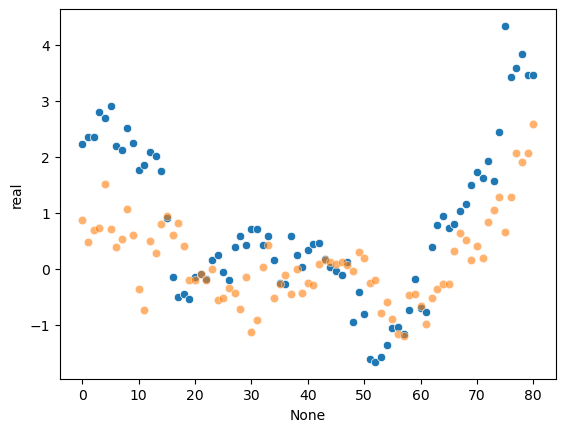

In [129]:
guardados=pd.DataFrame(columns=["real","predicciones","dif"])
guardados["real"]=y_real_guardadas
guardados["predicciones"]=y_pred_guardadas
sns.scatterplot(guardados,x=guardados.index,y=guardados["real"])
sns.scatterplot(guardados,x=guardados.index,y="predicciones",alpha=0.6)

In [71]:
guardados

,real,predicciones,dif
0,2.222381,0.812915,NaN
1,2.350967,0.480174,NaN
2,2.354678,0.717496,NaN
3,2.793022,0.808371,NaN
4,2.684797,1.544984,NaN
...,...,...,...
76,3.413945,1.402904,NaN
77,3.579624,2.083321,NaN
78,3.822046,1.870655,NaN
79,3.458305,2.062503,NaN


In [72]:
#hay que traducir a precio
#predio anterior-precio nuevo/precio anterior
#%*precioanterior--precioanterior
precios=[]
comparacion=pd.DataFrame(columns=["real","prediccion"])
rev=df_porcentual["close"].tail(len(guardados["predicciones"]))
rev.dropna(inplace=True)
rev.reset_index(drop=True,inplace=True)
for i in range(len(guardados["predicciones"])):
    precio=(rev[i])-((abs(guardados["predicciones"][i])/100)*(rev[i]))
    print(precio)
    precios.append(precio)
comparacion["real"]=rev
comparacion["prediccion"]=precios


114561.09289987627
114976.85738513422
114488.61214090421
114693.4751557943
113745.96640861414
114584.20718275565
114614.05628464218
114745.79835561418
114245.35553462373
114529.90627813408
114085.38173051218
113398.04407723395
113713.46189796952
114130.71287603439
113752.67858060157
112518.10550713475
111989.04843814395
111651.633186299
112236.7676488668
112130.76038845416
112717.96089931867
112860.31272247207
112682.55175216106
113018.43068653622
112256.78076736146
112203.57961217775
112171.83483747671
111908.28590671725
111603.12685525228
111994.52584940758
111750.57984770698
111817.64276756898
112576.98497666184
112282.06332854988
112097.50974912573
111682.3721653924
111760.03566942274
111756.80078040088
112376.2243387623
112083.70072882334
112680.3904397489
112588.51193410109
113052.78892604851
112863.20876033144
112822.06996185545
112831.13898595382
112741.98195115823
112901.18709401079
112469.99621328438
112516.91307056401
112647.27495536885
111658.64775837596
111571.63879970292


In [73]:
comparacion

,real,prediccion
0,115500.01,114561.092900
1,115531.61,114976.857385
2,115316.00,114488.612141
3,115628.18,114693.475156
4,115530.90,113745.966409
...,...,...
76,113639.80,112045.542274
77,113420.01,111057.107507
78,113501.52,111378.298471
79,113339.63,111001.996746


# XGBoots #

In [74]:
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV

In [113]:

relativ_error=[]
aciertos_direccion_list=[]
error_aciertos_list=[]
y_pred_guardadas=[]
y_real_guardadas=[]
restricciones=["open_time","pred_dia%"]
medir="pred_dia%"
for i in range(100):
    print(i)
    #vamos a separar los datos de entreno y los outsider
    entreno=df_porcentual[15000+i:21000+i]
    outsider=df_porcentual[21000+i+1:21000+i+2]
    #print(outsider)
    outsider.reset_index(drop=True,inplace=True)
    entreno.reset_index(drop=True,inplace=True)
    #ahora ponemos el y el x
    X_entreno=entreno.drop(restricciones,axis=1)
    y=entreno[medir]
    X_train, X_test, y_train, y_test = train_test_split(X_entreno, y, test_size=0.001, random_state=42)
    model=XGBRegressor(random_state=42,colsample_bytree=1.0, gamma= 0.5, learning_rate= 0.04 ,min_child_weight= 5, n_estimators= 500, reg_alpha= 0.01, reg_lambda= 0.5, subsample= 0.8)
    model.fit(X_train,y_train)
    X_outsider=outsider.drop(restricciones,axis=1)
    y_outsider=outsider[medir]#es el real
    predicciones_outsider=model.predict(X_outsider)
    #print(y_outsider[0])
    y_pred_guardadas.append(predicciones_outsider[0])
    y_real_guardadas.append(y_outsider[0])
    error_relativo_porcentual=abs(y_outsider[0]-predicciones_outsider)/y_outsider[0]
    relativ_error.append(error_relativo_porcentual)
    if y_outsider[0]*predicciones_outsider>0:
        aciertos_direccion_list.append(predicciones_outsider)
        error_relativo_aciertos=abs(y_outsider[0]-predicciones_outsider)/y_outsider[0]
        error_aciertos_list.append(error_relativo_aciertos)

error_total=abs(np.array(relativ_error).sum())/len(relativ_error)
aciertos_direccion=len(aciertos_direccion_list)
error_aciertos=abs(np.array(error_aciertos_list).sum())/len(error_aciertos_list)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


In [114]:
tabla_resultados=pd.DataFrame(columns=["error_total","error_aciertos","aciertos_direccion"])
tabla_resultados["error_total"]=error_total
tabla_resultados["error_aciertos"]=error_aciertos
tabla_resultados["aciertos_direccion"]=aciertos_direccion
print(f'error_aciertos: {error_aciertos}')
print(f'n_aciertos: {aciertos_direccion/len(relativ_error)}')
print(f'error total: {error_total}')


error_aciertos: 2.1153961797929175
n_aciertos: 0.75
error total: 0.7542242548011545


<Axes: xlabel='None', ylabel='real'>

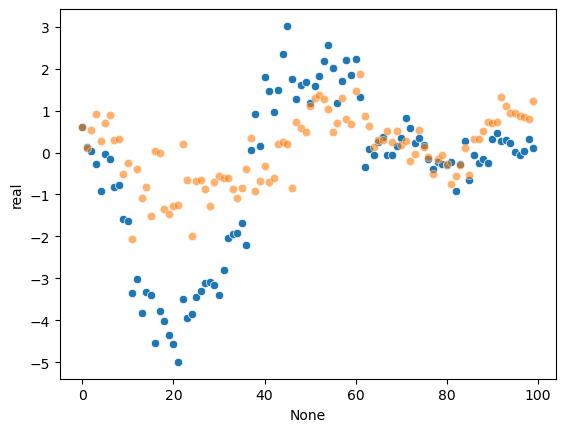

In [115]:
guardados=pd.DataFrame(columns=["real","predicciones","dif"])
guardados["real"]=y_real_guardadas
guardados["predicciones"]=y_pred_guardadas
sns.scatterplot(guardados,x=guardados.index,y=guardados["real"])
sns.scatterplot(guardados,x=guardados.index,y="predicciones",alpha=0.6)

In [124]:
def detectar_zonas_bajo_volumen(df, bins=80, n_zonas=100):
    """
    Calcula las zonas de bajo volumen (LVN) a partir de un perfil de volumen simple.

    bins: número de niveles de precios en el histograma
    n_zonas: cantidad de zonas de bajo volumen que quieres identificar
    """
    # Tomamos precio medio de cada vela
    df["precio_medio"] = (df["high"] + df["low"]) / 2
    precios = df["precio_medio"]
    volumenes = df["volume"]

    # Construir histograma ponderado por volumen
    hist, edges = np.histogram(precios, bins=bins, weights=volumenes)

    # Normalizamos
    hist = hist / hist.max()

    # Detectar los índices de menor volumen
    indices_lv = np.argsort(hist)[:n_zonas]
    zonas_bajo_volumen = [(edges[i], edges[i+1], hist[i]) for i in indices_lv]
   
    return zonas_bajo_volumen, hist, edges
zbv=detectar_zonas_bajo_volumen(df_porcentual)


In [125]:
zbv[0]

[(np.float64(122510.464625),
  np.float64(123862.95),
  np.float64(0.0011622287707119192)),
 (np.float64(31893.944499999998),
  np.float64(33246.429875),
  np.float64(0.002680333018541581)),
 (np.float64(121157.97924999999),
  np.float64(122510.464625),
  np.float64(0.0030933974698448795)),
 (np.float64(119805.493875),
  np.float64(121157.97924999999),
  np.float64(0.004393186043904317)),
 (np.float64(76525.961875),
  np.float64(77878.44725),
  np.float64(0.007116211452677171)),
 (np.float64(73820.991125),
  np.float64(75173.4765),
  np.float64(0.007509938767265073)),
 (np.float64(49476.254375000004),
  np.float64(50828.73974999999),
  np.float64(0.007753049300728211)),
 (np.float64(48123.769),
  np.float64(49476.254375000004),
  np.float64(0.007985578362468092)),
 (np.float64(77878.44725),
  np.float64(79230.932625),
  np.float64(0.008633290138246388)),
 (np.float64(72468.50575),
  np.float64(73820.991125),
  np.float64(0.009739660495129912)),
 (np.float64(113043.067),
  np.float64(11

In [ ]:
#agregar las zonas de bajo volumen
for i in zbv[0]:
    print(i)